In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import json
import Gantt_Chart

In [2]:
# pip install gurobipy

# 저자

- TA: 성준모 (Joonmo Sung)
- SYSTEMS MODELING AND PROGRAMMING LAB DEPARTMENT OF INDUSTRIAL ENGINEERING, YONSEI UNIVERSITY - SYMPLY
- 문의: `sjm21314@naver.com`,`sjm21314@yonsei.ac.kr`
***
본 강의자료는 Keha,A. B.,Khowala,K.,&Fowler,J. W. (2009). Mixed integer programming formulations for single machine scheduling problems. Computers & Industrial Engineering, 56(1), 357-367 논문을 바탕으로 제작되었으며,

반도체데이터사이언스 협동과정 수업 용도 이외의 목적으로 저자의 허락 없이 다른 사람들과 공유할 수 없습니다.

## Gurobi 참고사항
1. gurobi 12.0.1 version은 python 3.8 이전 버전에서는 작동하지 않음. 혹시 버전이 맞지 않으실 경우 아래 사이트에서 맞는 버전을 찾으시면 됩니다
- https://support.gurobi.com/hc/en-us/articles/360013195212-Which-Python-versions-are-supported-by-Gurobi
2. gurobi license 발급 후 cvxpy에서 solver를 gurobi를 선택하시는 것과 gurobipy에서 구현한 코드도 gurobi solver를 사용하는 것은 동일한 solver를 사용하나, gurobipy를 사용하는 것이 더 효율적일 것입니다
3. IP 문제로 academic license 발급이 어려우신 경우 학교 VPN을 이용할 수 있는 방법이 있습니다.

    3-1. 스마트폰에서 Authenticator 어플리케이션 설치 후 yonsei 계정으로 로그인

    3- 2. https://ysvpn.yonsei.ac.kr/ 으로 들어가셔서 어플리케이션에서 QR 찍으시고 인증 후 접속하시면 됩니다. 

## Dataset
### Set
- J = $\{1,2,...,n\}, j \in J$ (Job)
- $\mu$ = $\{1,2, ..., m\}, i \in \mu$ (Machine)
### Parameters
- $p_j$: processing time of job $j$
- $d_j$: due date of job $j$
- $w_j$: weight of job $j$
- $r_j$: release date of job $j$

In [3]:
with open('data.json') as file:
    data = json.load(file)

In [4]:
print(len(data['N']))
print(data['p'])
print(data['d'])
print(data['w'])
print(data['r'])

5
{'0': 1, '1': 15, '2': 12, '3': 13, '4': 9}
{'0': 30, '1': 5, '2': 15, '3': 22, '4': 40}
{'0': 6, '1': 3, '2': 2, '3': 5, '4': 2}
{'0': 22, '1': 16, '2': 15, '3': 4, '4': 10}


In [5]:
# Offline 상황을 가정.

n = len(data['N']) # 작업의 개수
m = 2 # 기계의 개수 

# Sets
J = [_ for _ in range(n)] # 작업 set을 리스트 자료구조를 이용해 0, 1, 2,..., n-1 까지 담아줌
Mu = [_ for _ in range(m)] # 기계 set을 리스트 자료구조를 이용해 0, 1, 2,..., m-1 까지 담아줌

# Parameters
p = [data['p'][f'{i}'] for i in J] # 작업의 가공시간 데이터를 리스트 자료구조를 이용해 만들어 줌
d = [data['d'][f'{i}'] for i in J] # 작업의 마감 기한 데이터를 리스트 자료구조를 이용해 만들어 줌
w = [data['w'][f'{i}'] for i in J] # 작업의 가중치 데이터를 리스트 자료구조를 이용해 만들어 줌
r = [data['r'][f'{i}'] for i in J] # 작업의 release date(도착 시점) 데이터를 리스트 자료구조를 이용해 만들어 줌

M = (sum(p) + sum(r)) * 2 # big M

In [6]:
print(p)
print(d)
print(w)
print(r)

[1, 15, 12, 13, 9]
[30, 5, 15, 22, 40]
[6, 3, 2, 5, 2]
[22, 16, 15, 4, 10]


In [7]:
# Create an environment with your WLS license
# params = {
# "WLSACCESSID": 'your wls accessid (string)',
# "WLSSECRET": 'your wls secret (string)',
# "LICENSEID": <your license id (integer)>,
# }
# env = gp.Env(params=params)

# # Create the model within the Gurobi environment
# model = gp.Model(env=env)

In [ ]:
obj_select = 'wct' # 'wct', 'tj', 'twt', 'L_max' 'C_max' 중 하나 선택
release_time = True

# Identical Parallel machines (Pm) 상황을 가정

## M1 - Time-indexed model formulation

### Sets
- $\tau$: Set of time periods, t = 1,2,...,l

In [9]:
l = sum(p) + max(r) # l은 마지막 작업의 종료 시점에 대한 upper bound
Tau = [_ for _ in range(l)] # Time horizon set 설정

### Decision Variables
- $x_{i,j,t}$: 작업 $j$가 머신 $i$에서 period t에서 시작하면 1, 아니면 0인 이진변수, $x_{i,j,t} \in \{0, 1\} \ \forall i \in \tau,  \forall j \in N, \forall t \in \tau$

In [10]:
# 모델 선언
model_MIP_1 = gp.Model("MIP_1") # 먼저 모델 선언 

# colab 경우
# model_MIP_1 = gp.Model("MIP_1", env = env) 

# Decision Variable 만들기
x =  {(i, j, t): model_MIP_1.addVar(vtype=GRB.BINARY, name=f"x_{i+1}_{j+1}_{t}") for i in Mu for j in J for t in Tau} 

Set parameter Username
Set parameter LicenseID to value 2583767
Academic license - for non-commercial use only - expires 2025-11-14


### 기본 constraint
- $\sum_{i \in \mu}\sum_{t=0}^{l-p_j+1} x_{i,j,t} = 1 \quad \forall j \in J$
- $\sum_{j \in J} \sum_{h = max(0, t-p_j+1)}^t x_{i,j,h} \leq 1 \quad \quad i \in \mu, \forall t \in \tau$

In [11]:
constraint1_1 = {(j): model_MIP_1.addConstr(quicksum(quicksum(x[i,j,t] for t in range(0, len(Tau)-p[j]+1)) for i in Mu) == 1, name = f"constraint1_1_{j}") for j in J}
constraint1_2 = {(i, t): model_MIP_1.addConstr(quicksum(quicksum(x[i,j,h] for h in range(max(0, t-p[j]+1), t + 1)) for j in J) <= 1, name = f"constraint1_2_{i}_{t}") for i in Mu for t in Tau}

#### Release time 반영 제약식
$ \sum_{i \in \mu} \sum_{t = 0}^{r_j -1} x_{i,j,t} = 0 \quad \forall j \in J $

In [12]:
if release_time == True:
    constrain1_3 = {(j): model_MIP_1.addConstr(quicksum(quicksum(x[i,j,t]  for t in range(0, r[j])) for i in Mu)== 0, name = f"constraint1_3_{j}") for j in J}

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $

In [13]:
if obj_select == "wct":
    # 작업의 종료 시점을 나타내는 C_j 선언
    C = {(j): model_MIP_1.addVar(vtype=GRB.CONTINUOUS, name = f"C_{j+1}") for j in J}

    # C_j 관련 제약식 추가
    constraint1_4 = {(j): model_MIP_1.addConstr(C[j] >= quicksum(quicksum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu), name = f"constraint1_4_{j}") for j in J}

    # 목적식
    model_MIP_1.setObjective(quicksum(w[j] * C[j] for j in J), GRB.MINIMIZE)

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [14]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 C_j와 T_j 선언
    C = {(j): model_MIP_1.addVar(vtype=GRB.CONTINUOUS, name = f"C_{j+1}") for j in J}
    T = {(j): model_MIP_1.addVar(vtype=GRB.CONTINUOUS, lb = 0, name = f"T_{j}") for j in J}

    # C_j 관련 제약식 추가
    constraint1_4 = {(j): model_MIP_1.addConstr(C[j] >= quicksum(quicksum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu), name = f"constraint1_4_{j}") for j in J}
    # T_j 제약식 추가
    constraint1_5 = {(j): model_MIP_1.addConstr(T[j] >= C[j] - d[j], name = f"constraint1_5_{j}") for j in J}

    # 목적식
    model_MIP_1.setObjective(quicksum(w[j] * T[j] for j in J), GRB.MINIMIZE)

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ C_j \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [15]:
if obj_select == "L_max":
     
    # 작업의 종료 시점을 나타내는 C_j와 L_max 선언
    C = {(j): model_MIP_1.addVar(vtype=GRB.CONTINUOUS, name = f"C_{j+1}") for j in J}
    L_max = model_MIP_1.addVar(vtype=GRB.CONTINUOUS, lb = -M, name= "L_max") # L_max를 나타내는 연속형 변수   

    # C_j 관련 제약식 추가
    constraint1_4 = {(j): model_MIP_1.addConstr(C[j] >= quicksum(quicksum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu), name = f"constraint1_4_{j}") for j in J}
    # L_max 제약식
    constraint1_5 = {(j): model_MIP_1.addConstr(L_max >= C[j] - d[j], name = f"constraint1_5_{j}") for j in J}

    # 목적식
    model_MIP_1.setObjective(L_max, GRB.MINIMIZE)

#### To minimize the number of tardy jobs
$ Minimize \ \sum_{i \in \mu}\sum_{j \in J}\sum_{t \in \tau}\frac{\max(0, t-d_j+p_j)}{\max(1, t - d_j + p_j)}x_{i,j,t}$

In [16]:
if obj_select == "tj":
    # 목적식
    model_MIP_1.setObjective(quicksum(quicksum(quicksum((max(0, t - d[j] + p[j]))/(max(1, t - d[j] + p[j])) * x[i,j,t] for t in Tau) for j in J) for i in Mu), GRB.MINIMIZE)

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq \sum_{i \in \mu}\sum_{t \in \Tau}(t + p_j) x_{i,j,t} \quad \forall j \in J $

In [17]:
if obj_select == 'C_max':

    # Makespan인 C_max 선언
    C_max = model_MIP_1.addVar(vtype=GRB.CONTINUOUS, name= "C_max") # C_max를 나타내는 연속형 변수

    # C_max 제약식
    constraint1_4 = {(j): model_MIP_1.addConstr(C_max >= quicksum(quicksum((t+p[j]) * x[i,j,t] for t in Tau) for i in Mu), name = f"constraint1_4_{j}") for j in J}

    # 목적식
    model_MIP_1.setObjective(C_max, GRB.MINIMIZE)

## M2 - Network model formulation

### Dummy node 
- 논문에서는 더미 노드를 0으로 설정하였으나, 코드에서는 인덱스가 0부터 시작하기 때문에, -1을 더미 노드로 설정
- $J_d$: dummy node가 포함된 작업의 집합
### Decision Variables
- $x_{i,l,j}$: 머신 $i$에서, 작업 $l$이 작업 $j$ 직전에 시작하면 1, 아니면 0인 이진변수, $x_{i,l,j} \in \{0, 1\} \ \forall j \in N, \forall k \in N$
- $C_j$: 작업 $j$의 종료 시점 의미

In [18]:
J_d = [-1] + J
print('J', J)
print('J_d', J_d)

model_MIP_2 = gp.Model("MIP_2")

# colab 경우
# model_MIP_2 = gp.Model("MIP_2", env = env) 

# Decision Variable 만들기
x = {(i, l, j): model_MIP_2.addVar(vtype=GRB.BINARY, name=f"x_{i+1}_{l+1}_{j+1}") for i in Mu for l in J_d for j in J_d}
C = {(j): model_MIP_2.addVar(vtype=GRB.CONTINUOUS, name = f"C_{j+1}") for j in J_d}

J [0, 1, 2, 3, 4]
J_d [-1, 0, 1, 2, 3, 4]


### 기본 constraint
- $ \sum_{i \in \mu}x_{i,l,-1} \leq 1 \quad \forall l \in J$ <- 논문 수식, 수정 필요: 이렇게 하면 한 기계에서밖에 작업을 못하게 됨 
- $ \sum_{i \in \mu}x_{i,-1,j} \leq 1 \quad \forall j \in J$ <- 논문 수식, 수정 필요: 이렇게 하면 한 기계에서밖에 작업을 못하게 됨 
- $ \sum_{l \in J}x_{i,l,-1} \leq 1 \quad \forall i \in \mu$ <- 논문 오류 있어 수정
- $ \sum_{j \in J}x_{i,-1,j} \leq 1 \quad \forall i \in \mu$ <- 논문 오류 있어 수정
- $ \sum_{l \in J_d}\sum_{i \in \mu}x_{i,l,j} = 1 \quad \forall j \in J, l \neq j$
- $ \sum_{j \in J_d}\sum_{i \in \mu}x_{i,l,j} = 1 \quad \forall l \in J, l \neq j$
- $ \sum_{l \in J_d, l \neq j}x_{i,l,j} - \sum_{l \in J_d, l \neq j}x_{i,j,l} = 0\quad \forall j \in J, \forall i \in \mu$
- $ C_l - C_j + (M - r_j)x_{i,l,j} \leq M - (r_j + p_j) \quad \forall l \in J_d, \forall j \in J, l \neq j, \forall i \in \mu$ <- release time이 제대로 반영되지 않음
- $ C_l - C_j + Mx_{i,l,j} \leq M - p_j \quad \forall l \in J_d, \forall j \in J, l \neq j, \forall i \in \mu$

In [19]:
constraint2_1 = {(i): model_MIP_2.addConstr(quicksum(x[i,l,-1] for l in J) <= 1, name = f"constraint2_1_{i}") for i in Mu}
constraint2_2 = {(i): model_MIP_2.addConstr(quicksum(x[i,-1,j] for j in J) <= 1, name = f"constraint2_2_{i}") for i in Mu}
constraint2_3 = {(j): model_MIP_2.addConstr(quicksum(quicksum(x[i,l,j] for i in Mu) for l in J_d if l != j) == 1, name = f"constraint2_3_{j}") for j in J}
constraint2_4 = {(l): model_MIP_2.addConstr(quicksum(quicksum(x[i,l,j] for i in Mu) for j in J_d if l != j) == 1, name = f"constraint2_4_{l}") for l in J}
constraint2_5 = {(i, j): model_MIP_2.addConstr(quicksum(x[i,l,j] for l in J_d if l != j) == quicksum(x[i,j,l] for l in J_d if l != j), name = f"constraint2_5_{i}_{j}") for i in Mu for j in J}
constraint2_6 = {(i, j, l): model_MIP_2.addConstr(C[l] - C[j] + M*x[i,l,j] <= M - p[j], name = f"constraint2_6_{i}_{j}_{l}") for i in Mu for l in J_d for j in J if l != j} # release time 0 처리

#### Release time 반영 제약식
$C_j \geq r_j + p_j\quad \forall j \in J$

In [20]:
if release_time == True:
    constraint2 = {(j): model_MIP_2.addConstr(C[j] >= r[j] + p[j], name = f"constraint2_{j}") for j in J}

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$

In [21]:
if obj_select == "wct":

    # 목적식
    model_MIP_2.setObjective(quicksum(w[j] * C[j] for j in J), GRB.MINIMIZE)

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [22]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 T_j 선언
    T = {(j): model_MIP_2.addVar(vtype=GRB.CONTINUOUS, lb = 0, name = f"T_{j}") for j in J}

    # T_j 제약식 추가
    constraint2 = {(j): model_MIP_2.addConstr(T[j] >= C[j] - d[j], name = f"constraint2_{j}") for j in J}

    # 목적식
    model_MIP_2.setObjective(quicksum(w[j] * T[j] for j in J), GRB.MINIMIZE)

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [23]:
if obj_select == "L_max":
     
    # L_max 선언
    L_max = model_MIP_2.addVar(vtype=GRB.CONTINUOUS, lb = -M, name= "L_max") # L_max를 나타내는 연속형 변수   

    # L_max 제약식
    constraint2 = {(j): model_MIP_2.addConstr(L_max >= C[j] - d[j], name = f"constraint2_{j}") for j in J}

    # 목적식
    model_MIP_2.setObjective(L_max, GRB.MINIMIZE)

#### To minimize the number of tardy jobs
- $ Minimize \ \sum_{j \in J}U_j$
- $ C_j \leq d_j + MU_j \quad \forall j \in J$
- $ U_j \in \{0, 1\}$

In [24]:
if obj_select == "tj":
    
    # 작업의 종료 시점을 나타내는 U_j 선언
    U = {(j): model_MIP_2.addVar(vtype=GRB.BINARY, name = f"U_{j}") for j in J}

    # U_j 제약식 추가
    constraint2 = {(j): model_MIP_2.addConstr(C[j] <= d[j] + M*U[j], name = f"constraint2_{j}") for j in J}

    # 목적식
    model_MIP_2.setObjective(quicksum(U[j] for j in J), GRB.MINIMIZE)

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq C_j \quad \forall j \in J $

In [25]:
if obj_select == 'C_max':

    # Makespan인 C_max 선언
    C_max = model_MIP_2.addVar(vtype=GRB.CONTINUOUS, name= "C_max") # C_max를 나타내는 연속형 변수

    # C_max 제약식
    constraint2 = {(j): model_MIP_2.addConstr(C_max >= C[j], name = f"constraint2_{j}") for j in J}

    # 목적식
    model_MIP_2.setObjective(C_max, GRB.MINIMIZE)

## M3 - Assignment and positional date model formulation

### Decision Variables
- $u_{i,j,l}$: 머신 $i$에서, 작업 $j$가 position $l$에 있으면 1, 아니면 0인 이진변수, $u_{i,j,l} \in \{0, 1\} \ \forall i \in \mu \ \forall j \in J, \forall l \in J$
- $\gamma_{i,l}$: 머신 $i$에서, position $l$에 있는 작업의 종료 시점 의미
- $C_j$: 작업 $j$의 종료 시점 의미


In [26]:
model_MIP_3 = gp.Model("MIP_3")

# colab 경우
# model_MIP_3 = gp.Model("MIP_3", env = env) 

# Decision Variable 만들기
u = {(i, j, l): model_MIP_3.addVar(vtype = GRB.BINARY, name = f"u_{i+1}_{j+1}_{l+1}") for i in Mu for j in J for l in J}
gamma = {(i, l): model_MIP_3.addVar(vtype=GRB.CONTINUOUS, lb = 0, name=f"gamma_{i+1}_{l+1}") for i in Mu for l in J}
C = {(j): model_MIP_3.addVar(vtype = GRB.CONTINUOUS, lb = 0, name = f"C_{j+1}") for j in J}

### 기본 constraint
- $\sum_{i \in \mu}\sum_{l \in J}u_{i,j,l} = 1 \quad \forall j \in J$
- $\sum_{j \in J} u_{i,j,l} \leq 1 \quad \forall i \in \mu, \forall l \in J$
- $\gamma_{i, 0} \geq \sum_{j \in J}p_j u_{i,j,0} \quad \forall i \in \mu$, 시작 index를 0으로 했기 때문
- $\gamma_{i, l} \geq \gamma_{i, l-1} + \sum_{j \in J}p_ju_{i,j,l} \quad \forall i \in \mu, \forall l \in J: \ l \geq 1 $
- $C_j \geq \gamma_{i,l} - M(1 - \mu_{i,j,l}) \quad \forall j \in J, \forall l \in J, \forall i \in \mu$
### 추가 제약식 ($\gamma$에서 poisition이 제대로 고정되지 않음)
- $C_j \leq \gamma_{i,l} + M(1 - u_{i,j,l}) \quad \forall i \in \mu, \forall j \in J, \forall l \in J$ -> gamma의 값을 고정
- $\sum_{j \in J}u_{i,j,l} \leq \sum_{j \in J} u_{i,j,l-1} \quad \forall i \in \mu, \forall l \in J: \ l \geq 1$ -> 포지션 고정

In [27]:
constraint3_1 = {(j): model_MIP_3.addConstr(quicksum(quicksum(u[i,j,l] for l in J) for i in Mu) == 1, name = f"constraint3_1_{j}") for j in J}
constraint3_2 = {(i, l): model_MIP_3.addConstr(quicksum(u[i,j,l] for j in J) <= 1, name = f"constraint3_2_{i}_{l}") for i in Mu for l in J}
constraint3_3 = {(i): model_MIP_3.addConstr(gamma[i, 0] >= quicksum(p[j] * u[i,j,0] for j in J), name = f"constraint3_3_{i}") for i in Mu}
constraint3_4 = {(i, l): model_MIP_3.addConstr(gamma[i,l] >= gamma[i,l-1] + quicksum(p[j] * u[i,j,l] for j in J), name = f"constraint3_4_{i}_{l}") for i in Mu for l in J[1:]}
constraint3_5 = {(i, j, l): model_MIP_3.addConstr(C[j] >= gamma[i, l] - M*(1 - u[i,j,l]), name = f"constraint3_5_{i}_{j}_{l}") for i in Mu for j in J for l in J}
constraint3_6 = {(i, j, l): model_MIP_3.addConstr(C[j] <= gamma[i, l] + M*(1 - u[i,j,l]), name = f"constraint3_6_{i}_{j}_{l}") for i in Mu for j in J for l in J}
constraint3_7 = {(i, l): model_MIP_3.addConstr(quicksum(u[i,j,l] for j in J) <= quicksum(u[i,j,l-1] for j in J), name = f"constraint3_7_{i}_{l}") for i in Mu for l in J[1:]}

#### Release time 반영 제약식
$ \gamma_{i,l} \geq \sum_{j \in J}(p_j + r_j)u_{i,j,l} \quad \forall i \in \mu \forall j \in J $

In [28]:
if release_time == True:
    constraint3_6 = {(i, l): model_MIP_3.addConstr(gamma[i, l] >= quicksum((p[j] + r[j]) * u[i,j,l] for j in J), name = f"constraint3_6_{i}_{l}") for i in Mu for l in J}

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$

In [29]:
if obj_select == "wct":

    # 목적식
    model_MIP_3.setObjective(quicksum(w[j] * C[j] for j in J), GRB.MINIMIZE)

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [30]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 T_j 선언
    T = {(j): model_MIP_3.addVar(vtype=GRB.CONTINUOUS, lb = 0, name = f"T_{j}") for j in J}

    # T_j 제약식 추가
    constraint3 = {(j): model_MIP_3.addConstr(T[j] >= C[j] - d[j], name = f"constraint3_{j}") for j in J}

    # 목적식
    model_MIP_3.setObjective(quicksum(w[j] * T[j] for j in J), GRB.MINIMIZE)

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [31]:
if obj_select == "L_max":
     
    # L_max 선언
    L_max = model_MIP_3.addVar(vtype=GRB.CONTINUOUS, lb = -M, name= "L_max") # L_max를 나타내는 연속형 변수   

    # L_max 제약식
    constraint3 = {(j): model_MIP_3.addConstr(L_max >= C[j] - d[j], name = f"constraint3_{j}") for j in J}

    # 목적식
    model_MIP_3.setObjective(L_max, GRB.MINIMIZE)

#### To minimize the number of tardy jobs
- $ Minimize \ \sum_{j \in J}U_j$
- $ C_j \leq d_j + MU_j \quad \forall j \in J$
- $ U_j \in \{0, 1\}$

In [32]:
if obj_select == "tj":
    
    # 작업의 종료 시점을 나타내는 U_j 선언
    U = {(j): model_MIP_3.addVar(vtype=GRB.BINARY, name = f"U_{j}") for j in J}

    # U_j 제약식 추가
    constraint3 = {(j): model_MIP_3.addConstr(C[j] <= d[j] + M*U[j], name = f"constraint3_{j}") for j in J}

    # 목적식
    model_MIP_3.setObjective(quicksum(U[j] for j in J), GRB.MINIMIZE)

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq C_j \quad \forall j \in J $

In [33]:
if obj_select == 'C_max':

    # Makespan인 C_max 선언
    C_max = model_MIP_3.addVar(vtype=GRB.CONTINUOUS, name= "C_max") # C_max를 나타내는 연속형 변수

    # C_max 제약식
    constraint3 = {(j): model_MIP_3.addConstr(C_max >= C[j], name = f"constraint3_{j}") for j in J}

    # 목적식
    model_MIP_3.setObjective(C_max, GRB.MINIMIZE)

## M4 - Linear ordering model formulation

### Decision Variables
- $\delta_{l,j}$: 작업 $l$가 작업 $j$보다 앞에서 시작하면 1, 아니면 0인 이진변수, $\delta_{l,j} \in \{0, 1\} \ \forall l \in J, \forall j \in J$
- $z_{l,i}$: 작업 $l$이 기계 $i$에 할당되면 1, 아니면 0인 이진변수, $z_{l,i} \in \{0, 1\} \quad \forall l \in J, \forall i \in \mu $
- $y_{l,j}$: 작업 $l$이 작업 $j$와 다른 기계에 있으면 1, 아니면 0인 이진변수, $ y_{l,j} \in \{0, 1\} \quad \forall l \in J, \forall j \in J$

In [34]:
model_MIP_4 = gp.Model("MIP_4")

# colab 경우
# model_MIP_4 = gp.Model("MIP_4", env = env) 

# Decision Variable 만들기
delta = {(l, j): model_MIP_4.addVar(vtype = GRB.BINARY, name = f"delta_{l+1}_{j+1}") for l in J for j in J}
z = {(l, i): model_MIP_4.addVar(vtype = GRB.BINARY, name = f"z_{l+1}_{i+1}") for l in J for i in Mu}
y = {(l, j): model_MIP_4.addVar(vtype = GRB.BINARY, name = f"y_{l+1}_{j+1}") for l in J for j in J}
C = {(j): model_MIP_4.addVar(vtype = GRB.CONTINUOUS, lb = 0, name = f"C_{j+1}") for j in J}

### 기본 constraint
- $\delta_{l,j} + \delta_{j,l} + y_{l,j} = 1 \quad \forall l \in J, \forall j \in J, l < j$
- $\delta_{l,j} + \delta_{j,k} + \delta_{k,l} \leq 2 \quad \forall l,j,k \in J, l < j < k $
- $z_{l,i} + z_{j,i} + y_{l,j} \leq 2 \quad \forall l \in J, \forall j \in J, l < j, \forall i \in \mu$
- $\sum_{i \in \mu}z_{l,i} = 1 \quad \forall l \in J$
- $C_j \geq p_jz_{j,i} \quad \forall j \in J, \forall i \in \mu$
- $C_j \geq C_l + p_j(\delta_{l,j} + z_{l,i} + z_{j,i} - 2) - M(1 - \delta_{l,j}) \quad \forall l \in J, \forall j \in J, \forall i \in \mu$

In [35]:
constraint4_1 = {(l, j): model_MIP_4.addConstr(delta[l,j] + delta[j,l] + y[l,j] == 1, name = f"constraint4_1_{l}_{j}") for l in J for j in J if l < j}
constraint4_2 = {(l, j, k): model_MIP_4.addConstr(delta[l,j] + delta[j,k] + delta[k,l] <= 2, name = f"constraint4_2_{l}_{j}_{k}") for l in J for j in J for k in J if l < j < k}
constraint4_3 = {(i, l, j): model_MIP_4.addConstr(z[l,i] + z[j,i] + y[l,j] <= 2, name = f"constraint4_3_{i}_{l}_{j}") for i in Mu for l in J for j in J if l < j}
constraint4_4 = {(l): model_MIP_4.addConstr(quicksum(z[l,i] for i in Mu) == 1, name = f"constraint4_4_{l}") for l in J}
constraint4_5 = {(i, j): model_MIP_4.addConstr(C[j] >= p[j]*z[j,i], name = f"constraint4_5_{i}_{j}") for i in Mu for j in J}
constraint4_6 = {(i, l, j): model_MIP_4.addConstr(C[j] >= C[l] + p[j]*(delta[l,j] + z[l,i] +z[j,i] - 2) - M*(1-delta[l,j]), name = f"constraint4_6_{i}_{l}_{j}") for i in Mu for l in J for j in J}

#### Release time 반영 제약식
$C_j \geq r_j + p_jz_{j,i} \quad \forall j \in J, \forall i \in \mu$

In [36]:
if release_time == True:

    constraint4_7 = {(i, j): model_MIP_4.addConstr(C[j] >= r[j] + p[j]*z[j,i], name = f"constraint4_7_{i}_{j}") for i in Mu for j in J}

#### To minimize the total weighted completion time
- $ Minimize \sum_{j \in J} w_j C_j$

In [37]:
if obj_select == "wct":

    # 목적식
    model_MIP_4.setObjective(quicksum(w[j] * C[j] for j in J), GRB.MINIMIZE)

#### To minimize the total weighted tardiness

- $ Minimize \sum_{j \in J} w_j T_j$
- $ T_j \geq C_j - d_j \quad \forall j \in J $

In [38]:
if obj_select == "twt":
    
    # 작업의 종료 시점을 나타내는 T_j 선언
    T = {(j): model_MIP_4.addVar(vtype=GRB.CONTINUOUS, lb = 0, name = f"T_{j}") for j in J}

    # T_j 제약식 추가
    constraint4 = {(j): model_MIP_4.addConstr(T[j] >= C[j] - d[j], name = f"constraint4_{j}") for j in J}

    # 목적식
    model_MIP_4.setObjective(quicksum(w[j] * T[j] for j in J), GRB.MINIMIZE)

#### To minimize $L_{max}$
- $ Minimize \ L_{max}$
- $ L_{max} \geq (C_j - d_j) \quad \forall j \in N$

In [39]:
if obj_select == "L_max":
     
    # L_max 선언
    L_max = model_MIP_4.addVar(vtype=GRB.CONTINUOUS, lb = -M, name= "L_max") # L_max를 나타내는 연속형 변수   

    # L_max 제약식
    constraint4 = {(j): model_MIP_4.addConstr(L_max >= C[j] - d[j], name = f"constraint4_{j}") for j in J}

    # 목적식
    model_MIP_4.setObjective(L_max, GRB.MINIMIZE)

#### To minimize the number of tardy jobs
- $ Minimize \ \sum_{j \in J}U_j$
- $ C_j \leq d_j + MU_j \quad \forall j \in J$
- $ U_j \in \{0, 1\}$

In [40]:
if obj_select == "tj":
    
    # 작업의 종료 시점을 나타내는 U_j 선언
    U = {(j): model_MIP_4.addVar(vtype=GRB.BINARY, name = f"U_{j}") for j in J}

    # U_j 제약식 추가
    constraint4 = {(j): model_MIP_4.addConstr(C[j] <= d[j] + M*U[j], name = f"constraint4_{j}") for j in J}

    # 목적식
    model_MIP_4.setObjective(quicksum(U[j] for j in J), GRB.MINIMIZE)

#### To minimize makespan
- $ Minimize \ C_{max} $
- $ C_{max} \geq C_j \quad \forall j \in J $

In [41]:
if obj_select == 'C_max':

    # Makespan인 C_max 선언
    C_max = model_MIP_4.addVar(vtype=GRB.CONTINUOUS, name= "C_max") # C_max를 나타내는 연속형 변수

    # C_max 제약식
    constraint4 = {(j): model_MIP_4.addConstr(C_max >= C[j], name = f"constraint4_{j}") for j in J}

    # 목적식
    model_MIP_4.setObjective(C_max, GRB.MINIMIZE)

In [42]:
print("-"*30, "MIP 1", "-" *30)
model_MIP_1.optimize()
print("-"*30, "MIP 2", "-" *30)
model_MIP_2.optimize()
print("-"*30, "MIP 3", "-" *30)
model_MIP_3.optimize()
print("-"*30, "MIP 4", "-" *30)
model_MIP_4.optimize()

------------------------------ MIP 1 ------------------------------
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 149 rows, 720 columns and 7260 nonzeros
Model fingerprint: 0x6146de9a
Variable types: 0 continuous, 720 integer (720 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
------------------------------ MIP 2 -----------------

In [43]:
# 목적식 value
print(model_MIP_1.ObjVal)
print(model_MIP_2.ObjVal)
print(model_MIP_3.ObjVal)
print(model_MIP_4.ObjVal)

0.0
0.0
0.0
0.0


In [44]:
# 문제 푸는 데 걸린 시간
print(round(model_MIP_1.RunTime, 3))
print(round(model_MIP_2.RunTime, 3))
print(round(model_MIP_3.RunTime, 3))
print(round(model_MIP_4.RunTime, 3))

0.008
0.008
0.008
0.008


In [45]:
# Objective solution 출력 과정
for v in model_MIP_1.getVars():
    if v.x > 1e-6:
        print(v.varName, v.x)

print("Objective value:", model_MIP_1.objVal)

x_1_3_42 1.0
x_1_4_58 1.0
x_1_5_13 1.0
x_2_1_18 1.0
x_2_2_38 1.0
Objective value: 0.0


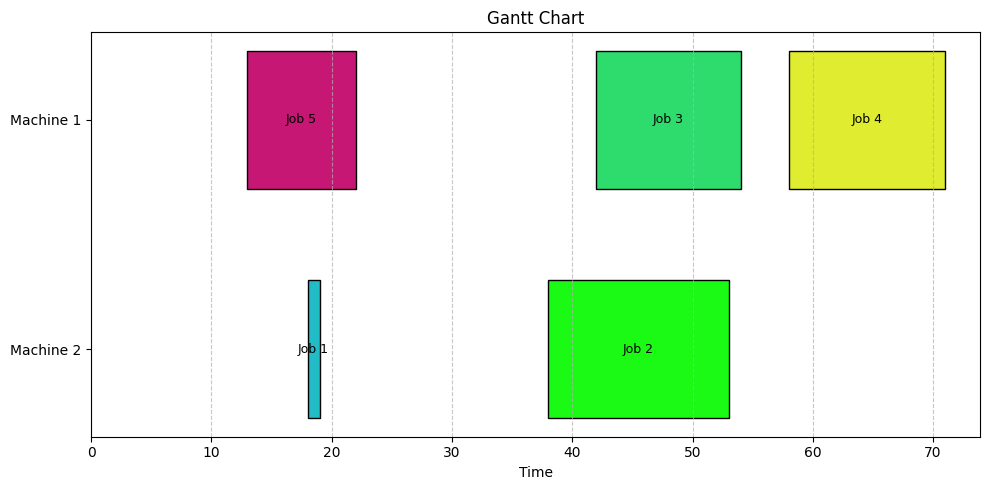

In [46]:
Gantt_Chart.M1_gurobi_gantt(model_MIP_1, p, J, m)

In [47]:
# Objective solution 출력 과정
for v in model_MIP_2.getVars():
    if v.x > 1e-6:
        print(v.varName, v.x)

print("Objective value:", model_MIP_2.objVal)

x_1_0_0 1.0
x_1_0_3 1.0
x_1_1_1 1.0
x_1_2_0 1.0
x_1_2_2 1.0
x_1_3_2 1.0
x_1_3_3 1.0
x_1_4_4 1.0
x_1_5_5 1.0
x_2_0_0 1.0
x_2_0_4 1.0
x_2_1_0 1.0
x_2_1_1 1.0
x_2_2_2 1.0
x_2_3_3 1.0
x_2_4_4 1.0
x_2_4_5 1.0
x_2_5_1 1.0
x_2_5_5 1.0
C_1 25.0
C_2 40.0
C_3 12.0
C_4 15.0
C_5 24.0
Objective value: 0.0


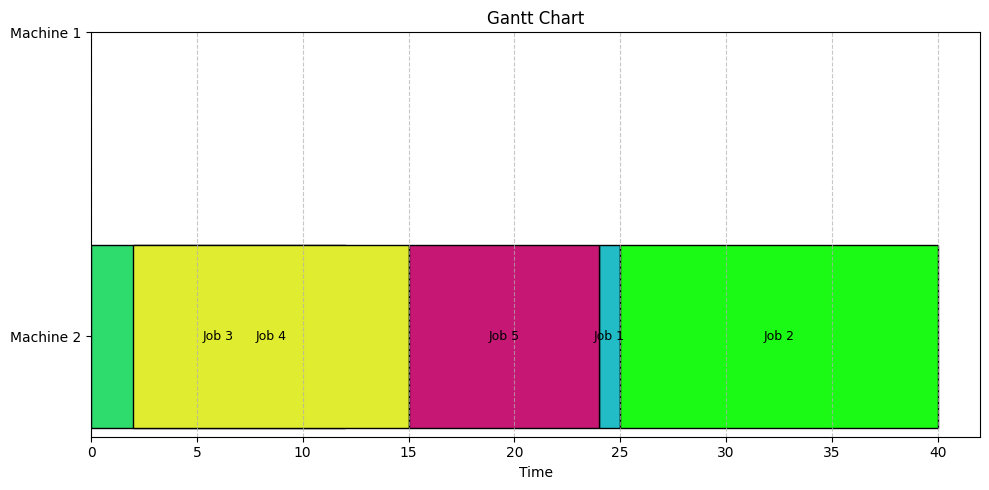

In [48]:
Gantt_Chart.M2_gurobi_gantt(model_MIP_2, p, J, m)

In [49]:
# Objective solution 출력 과정
for v in model_MIP_3.getVars():
    if v.x > 1e-6:
        print(v.varName, v.x)

print("Objective value:", model_MIP_3.objVal)

u_1_1_5 1.0
u_1_2_4 1.0
u_1_3_3 1.0
u_1_4_2 1.0
u_1_5_1 1.0
gamma_1_1 9.0
gamma_1_2 22.0
gamma_1_3 34.0
gamma_1_4 49.0
gamma_1_5 50.0
C_1 50.0
C_2 49.0
C_3 34.0
C_4 22.0
C_5 9.0
Objective value: 0.0


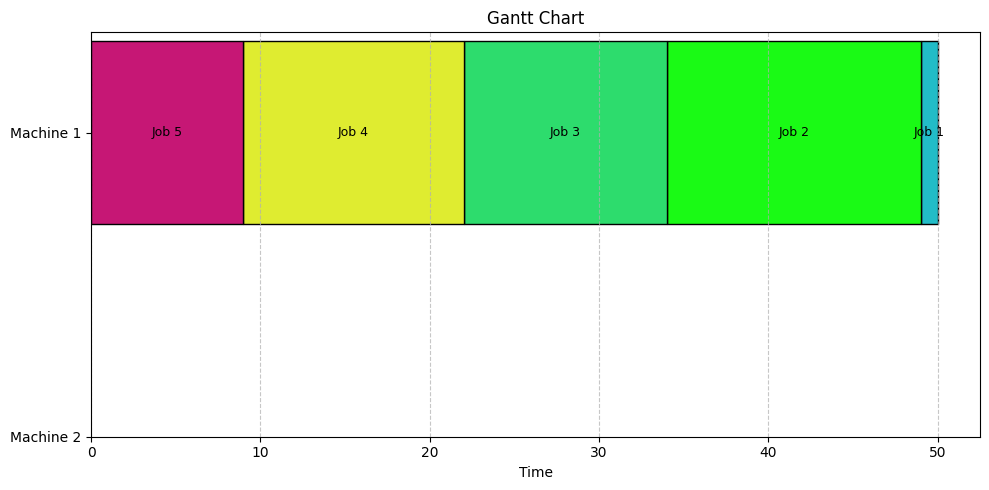

In [50]:
Gantt_Chart.M3_gurobi_gantt(model_MIP_3, p, J, m)

In [51]:
# Objective solution 출력 과정
for v in model_MIP_4.getVars():
    if v.x > 1e-6:
        print(v.varName, v.x)

print("Objective value:", model_MIP_4.objVal)

delta_1_2 1.0
delta_1_3 1.0
delta_2_3 1.0
delta_5_4 1.0
z_1_2 1.0
z_2_2 1.0
z_3_2 1.0
z_4_1 1.0
z_5_1 1.0
y_1_1 1.0
y_1_4 1.0
y_1_5 1.0
y_2_1 1.0
y_2_2 1.0
y_2_4 1.0
y_2_5 1.0
y_3_1 1.0
y_3_2 1.0
y_3_3 1.0
y_3_4 1.0
y_3_5 1.0
y_4_1 1.0
y_4_2 1.0
y_4_3 1.0
y_4_4 1.0
y_5_1 1.0
y_5_2 1.0
y_5_3 1.0
y_5_4 1.0
y_5_5 1.0
C_1 1.0
C_2 16.0
C_3 28.0
C_4 22.0
C_5 9.0
Objective value: 0.0


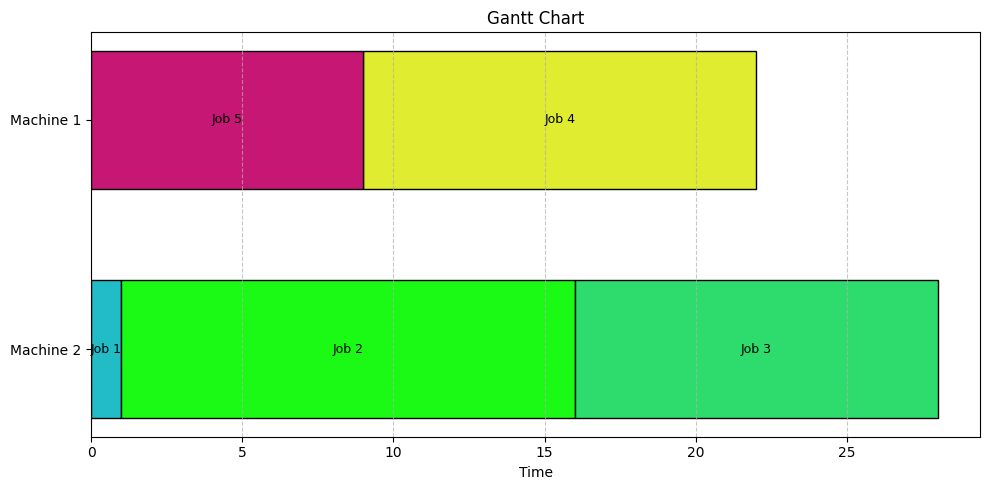

In [52]:
Gantt_Chart.M4_gurobi_gantt(model_MIP_4, p, J, m)